In [2]:
import os
import matplotlib.pyplot as plt

def save_fig(name, dpi=200):
    """Save figure into figures/ directory"""
    os.makedirs("figures", exist_ok=True)
    path = os.path.join("figures", f"{name}.png")
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[Saved] {path}")

In [9]:
import osmnx as ox
import networkx as nx

import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["font.size"] = 10

# ----------------------------
# City Configuration
# ----------------------------

# Bounding Box: (Min Latitude, Min Longitude, Max Latitude, Max Longitude)
CITY_BBOX = {
    "nyc": (40.4774, -74.2591, 40.9176, -73.7004),  # Approximate New York City
    "sg":  (1.2000, 103.6000, 1.4800, 104.0500),    # Singapore
    "ams": (52.2780, 4.7280, 52.4310, 5.0790),      # Amsterdam
    "sh":  (30.90, 121.00, 31.50, 121.98),          # Shanghai
}

CITY_LABEL = {
    "nyc": "New York City",
    "sg":  "Singapore",
    "ams": "Amsterdam",
    "sh":  "Shanghai",
}

# Projection used for area calculation per city
CITY_TARGET_CRS = {
    "nyc": "EPSG:3857",   
    "sg":  "EPSG:3414",   
    "ams": "EPSG:28992",  
    "sh":  "EPSG:3857",   
}

CITY_PLACE = {
    "nyc": "New York City, New York, USA",
    "sg":  "Singapore",
    "ams": "Amsterdam, Netherlands",
    "sh":  "Shanghai, China",
}

ox.settings.use_cache = True
ox.settings.cache_folder = "./osm_cache"  

def fetch_osm_walk_graph(city):
    place_name = CITY_PLACE[city]
    print(f"\nFetching OSM walk graph for {CITY_LABEL[city]} ({place_name}) ...")

    G = ox.graph_from_place(
        place_name,
        network_type="walk",  
        simplify=True
    )

    print(f"  → graph nodes={len(G.nodes)}, edges={len(G.edges)}")
    return G

In [10]:
OVERPASS_URLS = [
    "https://overpass-api.de/api/interpreter",
    "https://lz4.overpass-api.de/api/interpreter",
    "https://overpass.kumi.systems/api/interpreter",
]

# ---------------------------------------
# 1) Build Overpass query (for AMS / SH)
# ---------------------------------------
def build_overpass_query_bus_stops(bbox):
    """
    bbox: (min_lat, min_lon, max_lat, max_lon)
    """
    min_lat, min_lon, max_lat, max_lon = bbox
    query = f"""
    [out:json][timeout:120];
    (
      node["highway"="bus_stop"]({min_lat},{min_lon},{max_lat},{max_lon});
    );
    out body;
    >;
    out skel qt;
    """
    return query


# ---------------------------------------
# 2) Unified Bus Stop Retrieval Function
#    NYC / SG use local files, AMS / SH use Overpass
# ---------------------------------------
def fetch_bus_stops_osm(city):
    print(f"\nFetching bus stops for {CITY_LABEL[city]} ...")

    # New York City — Local GeoJSON
    if city == "nyc":
        path = "data/Bus_Stop_Shelter_20251122.geojson"
        print(f"  → Using local NYC dataset: {path}")
        gdf = gpd.read_file(path)

        if gdf.crs is None:
            gdf = gdf.set_crs("EPSG:4326")
        else:
            gdf = gdf.to_crs("EPSG:4326")

        print(f"  NYC loaded: {len(gdf)} stops")
        return gdf

    # Singapore — Local LTA GeoJSON
    if city == "sg":
        path = "data/LTABusStop.geojson"
        print(f"  → Using local Singapore dataset: {path}")
        gdf = gpd.read_file(path)

        if gdf.crs is None:
            gdf = gdf.set_crs("EPSG:4326")
        else:
            gdf = gdf.to_crs("EPSG:4326")

        print("  Singapore loaded")
        return gdf

# Amsterdam / Shanghai — Overpass API
    bbox = CITY_BBOX[city]
    query = build_overpass_query_bus_stops(bbox)

    print("  → Fetching from Overpass API ...")
    last_err = None
    resp = None
    data = None

    for url in OVERPASS_URLS:
        try:
            print(f"    trying: {url}")
            resp = requests.get(url, params={"data": query}, timeout=180)
            resp.raise_for_status()
            data = resp.json()
            print("    ✓ success")
            break
        except Exception as e:
            print(f"    ✗ failed on {url}: {e}")
            last_err = e
            continue

    if data is None:
        raise last_err


    elements = [e for e in data.get("elements", []) if e.get("type") == "node"]

    gdf = gpd.GeoDataFrame(
        elements,
        geometry=[Point(e["lon"], e["lat"]) for e in elements],
        crs="EPSG:4326",
    )

    if "tags" in gdf.columns:
        tags_df = gdf["tags"].apply(pd.Series)
        gdf = pd.concat([gdf.drop(columns=["tags"]), tags_df], axis=1)

    print(f"  {CITY_LABEL[city]} fetched: {len(gdf)} stops")
    return gdf

# ---------------------------------------
# 3) Boundary Cleaning (Applicable to All Cities)
# ---------------------------------------
def clean_boundary(gdf):
    """Fix topology and merge multiple polygons"""
    gdf = gdf.explode(ignore_index=True)
    gdf["geometry"] = gdf.geometry.buffer(0)
    merged = gdf.unary_union
    return gpd.GeoDataFrame(geometry=[merged], crs=gdf.crs)

In [11]:
# ------------------------------
# 1) Four Cities' Boundary Sources
# ------------------------------
BOUNDARY_SOURCES = {
    # New York City 
    "nyc": {
        "path": "data/nybb.shp"
    },

    # Singapore
    "sg": {
        "path": "data/Singapore_Boundary.geojson"
    },

    # Amsterdam
    "ams": {
        "path": "https://api.data.amsterdam.nl/v1/gebieden/stadsdelen?_format=geojson"
    },

    # Shanghai 
    "sh": {
        "path": "data/China_Boundary.json"
    },
}


# ------------------------------
# 2) Load city boundary
# ------------------------------
def load_city_boundary(city):
    path = BOUNDARY_SOURCES[city]["path"]

    print(f"\n=== Loading boundary for {CITY_LABEL[city]} ===")
    print(f"  Reading from: {path}")

    gdf = gpd.read_file(path)

    # Uniform CRS
    if gdf.crs is None:
        gdf = gdf.set_crs(epsg=4326)
    else:
        gdf = gdf.to_crs(epsg=4326)

    # Shanghai：Filter into Shanghai Municipality 
    if city == "sh":
        if "adm1_code" in gdf.columns:
            gdf = gdf[gdf["adm1_code"] == "CNSH"]
        elif "iso_3166_2" in gdf.columns:
            gdf = gdf[gdf["iso_3166_2"] == "CNSH"]
        elif "name" in gdf.columns:
            gdf = gdf[gdf["name"].str.contains("Shanghai", case=False, na=False)]

        print("  → Filtered Shanghai Municipality (CNSH, all polygons kept)")

    print(f"  → {len(gdf)} polygons, CRS = {gdf.crs}")
    return gdf

In [12]:
# Prepare city data: clip + area + density + network graph
def prepare_city_data(city):
    print(f"\n=== Processing {CITY_LABEL[city]} ===")

    G_walk = fetch_osm_walk_graph(city)

    # 1) Load bus stops (EPSG:4326)
    stops = fetch_bus_stops_osm(city)
    if len(stops) == 0:
        print("⚠ No bus stops, skip")
        return None

    stops_gdf = gpd.GeoDataFrame(stops, geometry=stops.geometry, crs="EPSG:4326")

    # 2) Load city boundaries
    boundary_raw = load_city_boundary(city)

    # 3) General cleaning (topology repair + merge)
    boundary = clean_boundary(boundary_raw)
    boundary_4326 = boundary.to_crs("EPSG:4326")

    # 4) Clip: Retain only stops within the city
    stops_clipped = gpd.clip(stops_gdf, boundary_4326)

    # 5) Project to target CRS
    target_crs = CITY_TARGET_CRS[city]
    boundary_proj = boundary_4326.to_crs(target_crs)
    stops_proj = stops_clipped.to_crs(target_crs)

    # 5.1 Street Network Projection
    G_proj = ox.project_graph(G_walk, to_crs=target_crs)
    nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj)

    # 6) Area & density
    area_m2 = boundary_proj.geometry.area.sum()
    area_km2 = area_m2 / 1e6

    n_stops = len(stops_proj)
    density = n_stops / area_km2 if area_km2 > 0 else None

    print(
        f"{CITY_LABEL[city]} area ≈ {area_km2:.1f} km², "
        f"stops={n_stops}, density={density:.3f}"
    )

    return {
        "boundary_4326": boundary_4326,
        "boundary_proj": boundary_proj,
        "stops_4326": stops_gdf,
        "stops_clipped_4326": stops_clipped,
        "stops_proj": stops_proj,
        "area_km2": area_km2,
        "n_stops": n_stops,
        "density": density,
        "G_walk": G_walk,
        "G_proj": G_proj,
        "nodes_proj": nodes_proj,
        "edges_proj": edges_proj,
    }

In [13]:
def plot_city_map(city, data, save=False):
    b = data["boundary_4326"]
    s = data["stops_clipped_4326"]

    fig, ax = plt.subplots(figsize=(6, 6))
    b.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
    s.plot(ax=ax, color="red", markersize=2)
    ax.set_title(f"{CITY_LABEL[city]}: Bus Stops")

    if save:
        save_fig(f"{city}_bus_stops")

    plt.show()


=== Processing New York City ===

Fetching OSM walk graph for New York City (New York City, New York, USA) ...
  → graph nodes=267568, edges=860004

Fetching bus stops for New York City ...
  → Using local NYC dataset: data/Bus_Stop_Shelter_20251122.geojson
  NYC loaded: 3381 stops

=== Loading boundary for New York City ===
  Reading from: data/nybb.shp
  → 5 polygons, CRS = EPSG:4326


C:\Users\Eve Li\AppData\Local\Temp\ipykernel_35832\404197951.py:112: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged = gdf.unary_union


New York City area ≈ 1362.7 km², stops=3381, density=2.481

=== Processing Singapore ===

Fetching OSM walk graph for Singapore (Singapore) ...
  → graph nodes=180152, edges=508528

Fetching bus stops for Singapore ...
  → Using local Singapore dataset: data/LTABusStop.geojson
  Singapore loaded

=== Loading boundary for Singapore ===
  Reading from: data/Singapore_Boundary.geojson
  → 55 polygons, CRS = EPSG:4326


C:\Users\Eve Li\AppData\Local\Temp\ipykernel_35832\404197951.py:112: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged = gdf.unary_union


Singapore area ≈ 784.9 km², stops=5161, density=6.575

=== Processing Amsterdam ===

Fetching OSM walk graph for Amsterdam (Amsterdam, Netherlands) ...
  → graph nodes=48778, edges=135830

Fetching bus stops for Amsterdam ...
  → Fetching from Overpass API ...
    trying: https://overpass-api.de/api/interpreter
    ✓ success
  Amsterdam fetched: 1592 stops

=== Loading boundary for Amsterdam ===
  Reading from: https://api.data.amsterdam.nl/v1/gebieden/stadsdelen?_format=geojson
  → 9 polygons, CRS = EPSG:4326


C:\Users\Eve Li\AppData\Local\Temp\ipykernel_35832\404197951.py:112: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged = gdf.unary_union


Amsterdam area ≈ 243.7 km², stops=1145, density=4.699

=== Processing Shanghai ===

Fetching OSM walk graph for Shanghai (Shanghai, China) ...


C:\Program Files\ArcGIS\Pro\bin\Python\envs\osm\lib\site-packages\osmnx\_overpass.py:271: UserWarning: This area is 28 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


  → graph nodes=169379, edges=486902

Fetching bus stops for Shanghai ...
  → Fetching from Overpass API ...
    trying: https://overpass-api.de/api/interpreter
    ✓ success
  Shanghai fetched: 24189 stops

=== Loading boundary for Shanghai ===
  Reading from: data/China_Boundary.json
  → Filtered Shanghai Municipality (CNSH, all polygons kept)
  → 1 polygons, CRS = EPSG:4326


C:\Users\Eve Li\AppData\Local\Temp\ipykernel_35832\404197951.py:112: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged = gdf.unary_union


Shanghai area ≈ 8114.9 km², stops=23273, density=2.868
[Saved] figures\nyc_bus_stops.png


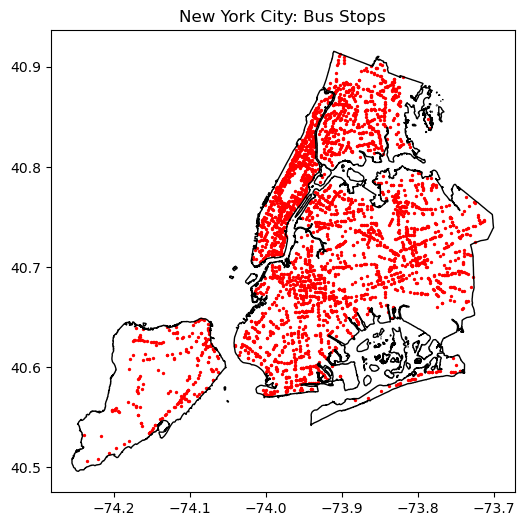

[Saved] figures\sg_bus_stops.png


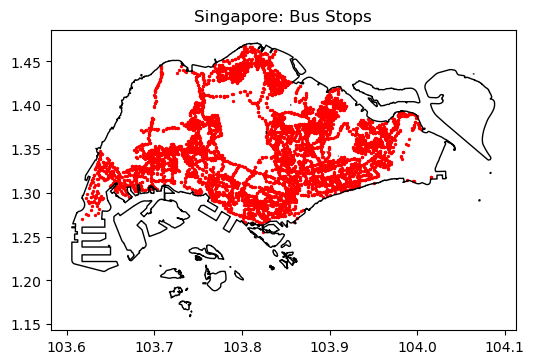

[Saved] figures\ams_bus_stops.png


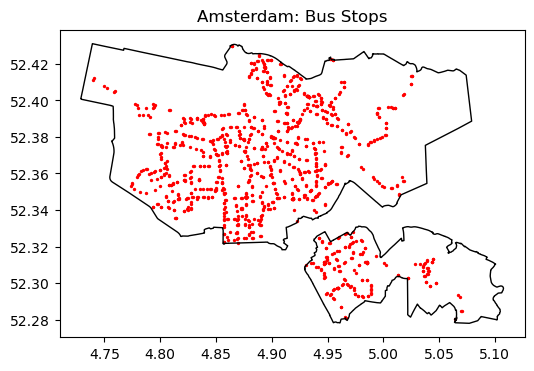

[Saved] figures\sh_bus_stops.png


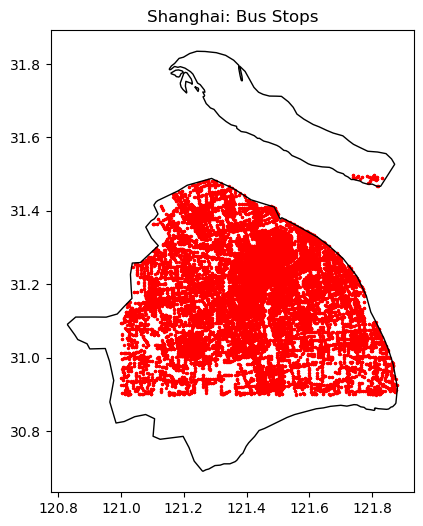


=== Density Summary ===
            city     area_km2  n_stops  density_stops_per_km2
0  New York City  1362.686006     3381               2.481129
1      Singapore   784.920610     5161               6.575187
2      Amsterdam   243.652458     1145               4.699316
3       Shanghai  8114.928199    23273               2.867924
[Saved] figures\density_bar_chart.png


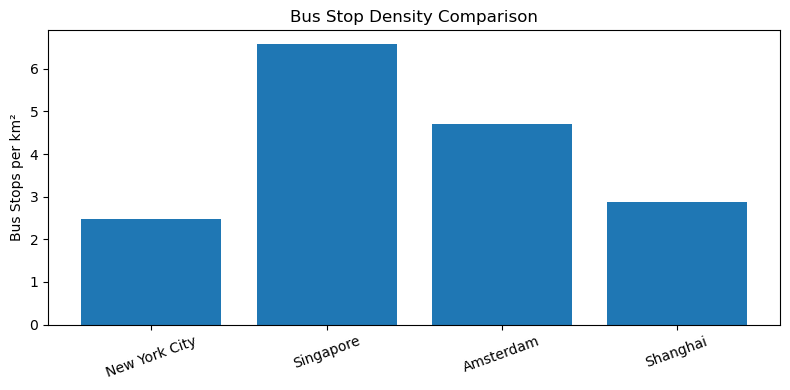

[Saved] figures\density_summary_table.png


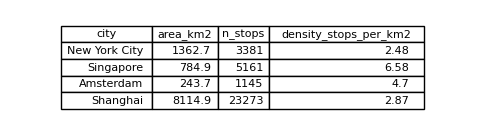

In [14]:
# ------------------------------
# Calculate Density for Four Cities
# ------------------------------
results = {}
for c in ["nyc", "sg", "ams", "sh"]:
    r = prepare_city_data(c)
    if r is not None:
        results[c] = r

# ------------------------------
# Individual city map plotting + saving
# ------------------------------
for c, r in results.items():
    plot_city_map(c, r, save=True)


# ------------------------------
# Summary DataFrame
# ------------------------------
summary_df = pd.DataFrame([
    {
        "city": CITY_LABEL[c],
        "area_km2": r["area_km2"],
        "n_stops": r["n_stops"],
        "density_stops_per_km2": r["density"]
    }
    for c, r in results.items()
])

print("\n=== Density Summary ===")
print(summary_df)


# ------------------------------
# Plot density comparison bar chart + saving
# ------------------------------
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(
    summary_df["city"],
    summary_df["density_stops_per_km2"]
)

ax.set_ylabel("Bus Stops per km²")
ax.set_title("Bus Stop Density Comparison")
plt.xticks(rotation=20)
plt.tight_layout()

save_fig("density_bar_chart")   
plt.show()


# ------------------------------
# Save summary_df as a table figure
# ------------------------------
fig, ax = plt.subplots(figsize=(6, 1.5))
ax.axis("off")

summary_to_show = summary_df.copy()
summary_to_show["area_km2"] = summary_to_show["area_km2"].round(1)
summary_to_show["density_stops_per_km2"] = summary_to_show["density_stops_per_km2"].round(2)

table = ax.table(
    cellText=summary_to_show.values,
    colLabels=summary_to_show.columns,
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(summary_to_show.columns))))

save_fig("density_summary_table")  # figures/density_summary_table.png
plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point
from shapely.ops import unary_union
import geopandas as gpd

In [16]:
# ======================================================
# 1) 500m Euclidean Coverage + Map
# ======================================================

from shapely.ops import unary_union
import matplotlib.pyplot as plt
import geopandas as gpd

def bus_coverage_analysis(city, result, buffer_m=500, plot=True):
    stops_proj = result["stops_proj"]
    boundary_proj = result["boundary_proj"]

    if stops_proj.empty:
        print(f"⚠ {CITY_LABEL[city]}: no stops in stops_proj.")
        return None, None

    # 1) Euclidean geometry buffer
    buffers = stops_proj.buffer(buffer_m)
    merged = unary_union(buffers)

    # 2) intersecting with the city boundary
    coverage_geom = gpd.GeoDataFrame(
        geometry=[merged],
        crs=boundary_proj.crs
    )
    covered = gpd.overlay(coverage_geom, boundary_proj, how="intersection")

    if covered.empty:
        print(f"⚠ {CITY_LABEL[city]}: covered area is empty.")
        return None, None

    covered_area = covered.geometry.area.sum()
    total_area = boundary_proj.geometry.area.sum()
    coverage = covered_area / total_area if total_area > 0 else None

    fig = None
    if plot:
        fig, ax = plt.subplots(figsize=(7, 7))
        boundary_proj.boundary.plot(ax=ax, color="black")
        covered.plot(ax=ax, alpha=0.5)
        stops_proj.plot(ax=ax, color="red", markersize=5)
        ax.set_title(f"{CITY_LABEL[city]} – {buffer_m}m Euclidean Coverage")
        ax.set_axis_off()
        return coverage, fig

    return coverage, None


# ======================================================
# 2) Network Buffer + Map
# ======================================================

def make_network_coverage_polygon(result, buffer_m=500, street_buffer=40):
    G_proj = result["G_proj"]
    boundary_proj = result["boundary_proj"]
    stops_proj = result["stops_proj"]

    if stops_proj.empty:
        print("⚠ No stops in city (stops_proj empty)")
        return None

    # 1) Snap the site to the nearest network node (coordinate system unified to target_crs)
    xs = stops_proj.geometry.x.values
    ys = stops_proj.geometry.y.values
    stop_nodes = ox.distance.nearest_nodes(G_proj, X=xs, Y=ys)

    # 2) Perform a single-source shortest path calculation for each site node, collecting all reachable nodes within buffer_m
    nodes_within = set()
    for sn in stop_nodes:
        lengths = nx.single_source_dijkstra_path_length(
            G_proj,
            sn,
            cutoff=buffer_m,
            weight="length"  
        )
        nodes_within.update(lengths.keys())

    if not nodes_within:
        print("⚠ No reachable nodes within buffer_m, return None")
        return None

    # 3) Subgraph extraction
    G_sub = G_proj.subgraph(nodes_within).copy()
    nodes_sub, edges_sub = ox.graph_to_gdfs(G_sub)

    if edges_sub.empty:
        print("⚠ No edges in subgraph, return None")
        return None

    # 4) Buffer accessible roads (line → surface)
    edge_buffers = edges_sub.geometry.buffer(street_buffer)
    merged = unary_union(edge_buffers)

    # 5) Intersecting with the city boundary yields the final coverage area
    coverage_geom = gpd.GeoDataFrame(
        geometry=[merged],
        crs=boundary_proj.crs
    )
    coverage_clipped = gpd.overlay(
        coverage_geom,
        boundary_proj,
        how="intersection"
    )

    return coverage_clipped


def bus_network_coverage(city, result, buffer_m=500, street_buffer=40, plot=True):
    if result is None:
        print(f"⚠ {CITY_LABEL[city]}: result is None, skip.")
        return None, None

    boundary_proj = result["boundary_proj"]

    coverage_gdf = make_network_coverage_polygon(
        result,
        buffer_m=buffer_m,
        street_buffer=street_buffer
    )

    if coverage_gdf is None or coverage_gdf.empty:
        print(f"⚠ {CITY_LABEL[city]}: coverage polygon is empty.")
        return None, None

    covered_area = coverage_gdf.geometry.area.sum()
    total_area = boundary_proj.geometry.area.sum()
    coverage_ratio = covered_area / total_area if total_area > 0 else None

    fig = None
    if plot:
        fig, ax = plt.subplots(figsize=(7, 7))
        boundary_proj.boundary.plot(ax=ax, color="black", linewidth=0.8)
        coverage_gdf.plot(ax=ax, alpha=0.5)
        result["stops_proj"].plot(ax=ax, color="red", markersize=4)
        ax.set_title(
            f"{CITY_LABEL[city]} – {buffer_m}m Network Buffer Coverage\n"
            f"(coverage ≈ {coverage_ratio:.3f})"
        )
        ax.set_axis_off()

    return coverage_ratio, fig


# ======================================================
# 3) KDE Heatmap (Kernel Density Estimation)
# ======================================================

from sklearn.neighbors import KernelDensity
import numpy as np

def bus_kde_heatmap(city, result, bandwidth_m=300, grid_size=200):
    stops_proj = result["stops_proj"]
    boundary_proj = result["boundary_proj"]

    X = np.vstack([stops_proj.geometry.x, stops_proj.geometry.y]).T
    kde = KernelDensity(bandwidth=bandwidth_m, kernel="gaussian")
    kde.fit(X)

    minx, miny, maxx, maxy = boundary_proj.total_bounds
    xx, yy = np.meshgrid(
        np.linspace(minx, maxx, grid_size),
        np.linspace(miny, maxy, grid_size)
    )
    xy_sample = np.vstack([xx.ravel(), yy.ravel()]).T
    zz = np.exp(kde.score_samples(xy_sample)).reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(zz, extent=(minx, maxx, miny, maxy), origin="lower", cmap="hot", alpha=0.6)
    boundary_proj.boundary.plot(ax=ax, color="black", linewidth=1)
    ax.set_title(f"{CITY_LABEL[city]} — KDE Heatmap")

    return xx, yy, zz, fig


# ======================================================
# 4) Nearest Neighbor Distance
# ======================================================

from sklearn.neighbors import KDTree

def nearest_stop_analysis(city, result, plot=True):
    stops_proj = result["stops_proj"]
    coords = np.vstack([stops_proj.geometry.x, stops_proj.geometry.y]).T

    tree = KDTree(coords)
    dist, _ = tree.query(coords, k=2)
    stops_proj = stops_proj.copy()
    stops_proj["nn_dist"] = dist[:, 1]

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        
        ax[0].hist(stops_proj["nn_dist"], bins=40, color="gray")
        ax[0].set_title(f"{CITY_LABEL[city]} — NN Distance Histogram")

        boundary_proj = result["boundary_proj"]
        boundary_proj.boundary.plot(ax=ax[1], color="black")
        stops_proj.plot(ax=ax[1], column="nn_dist", cmap="viridis", markersize=5, legend=True)
        ax[1].set_title(f"{CITY_LABEL[city]} — Nearest Stop Distance Map")

        return stops_proj, fig

    return stops_proj, None


In [17]:
# ======================================================
# 4) Full City Section: Save All 4 Figures
# ======================================================

def full_city_section(city, result, buffer_m=500, bandwidth_m=300, grid_size=200):
    print("\n" + "="*60)
    print(f"########  {CITY_LABEL[city]} — Full Analysis  ########")
    print("="*60)

    # 1) Euclidean 500m Coverage map
    cov_euc, fig_cov_euc = bus_coverage_analysis(
        city,
        result,
        buffer_m=buffer_m,
        plot=True
    )
    if fig_cov_euc is not None:
        save_fig(f"{city}_coverage_500m")
        plt.close(fig_cov_euc)

    # 2) Network Buffer Coverage map
    cov_net, fig_cov_net = bus_network_coverage(
        city,
        result,
        buffer_m=buffer_m,
        street_buffer=40,
        plot=True
    )
    if fig_cov_net is not None:
        save_fig(f"{city}_coverage_{buffer_m}m_network")
        plt.close(fig_cov_net)

    # 3) KDE
    xx, yy, zz, fig_kde = bus_kde_heatmap(
        city,
        result,
        bandwidth_m=bandwidth_m,
        grid_size=grid_size
    )
    if fig_kde is not None:
        save_fig(f"{city}_kde_bw{bandwidth_m}")
        plt.close(fig_kde)

    # 4) Nearest Neighbor
    nn_gdf, fig_nn = nearest_stop_analysis(city, result, plot=True)
    if fig_nn is not None:
        save_fig(f"{city}_nearest_neighbor")
        plt.close(fig_nn)

    return {
        "coverage_500m_euclidean": cov_euc,
        "coverage_500m_network": cov_net,
        "kde": (xx, yy, zz),
        "nearest": nn_gdf,
    }


In [18]:
BANDWIDTH_CONFIG = {
    "nyc": 400,
    "sg": 300,
    "ams": 250,
    "sh": 350,
}

detail_stats = {}

for c, r in results.items():
    bw = BANDWIDTH_CONFIG[c]
    detail_stats[c] = full_city_section(
        c,
        r,
        buffer_m=500,
        bandwidth_m=bw,
        grid_size=200
    )


########  New York City — Full Analysis  ########
[Saved] figures\nyc_coverage_500m.png
[Saved] figures\nyc_coverage_500m_network.png
[Saved] figures\nyc_kde_bw400.png
[Saved] figures\nyc_nearest_neighbor.png

########  Singapore — Full Analysis  ########
[Saved] figures\sg_coverage_500m.png
[Saved] figures\sg_coverage_500m_network.png
[Saved] figures\sg_kde_bw300.png
[Saved] figures\sg_nearest_neighbor.png

########  Amsterdam — Full Analysis  ########
[Saved] figures\ams_coverage_500m.png
[Saved] figures\ams_coverage_500m_network.png
[Saved] figures\ams_kde_bw250.png
[Saved] figures\ams_nearest_neighbor.png

########  Shanghai — Full Analysis  ########
[Saved] figures\sh_coverage_500m.png
[Saved] figures\sh_coverage_500m_network.png
[Saved] figures\sh_kde_bw350.png
[Saved] figures\sh_nearest_neighbor.png



=== Detailed Accessibility Summary ===
  city_code           city  area_km2  cov_euclid_ratio  cov_euclid_pct  \
0       nyc  New York City    1362.7          0.561071            56.1   
1        sg      Singapore     784.9          0.558901            55.9   
2       ams      Amsterdam     243.7          0.567725            56.8   
3        sh       Shanghai    8114.9          0.475103            47.5   

   area_cov_euclid_km2  cov_network_ratio  cov_network_pct  \
0                764.6           0.432650             43.3   
1                438.7           0.340349             34.0   
2                138.3           0.296061             29.6   
3               3855.4           0.157866             15.8   

   area_cov_network_km2  nn_mean_m  nn_median_m  nn_p90_m  nn_min_m  nn_max_m  \
0                 589.6      183.2        108.2     393.7       0.1    2417.4   
1                 267.1       79.7         57.1     161.4       0.0    1098.4   
2                  72.1       63.3 

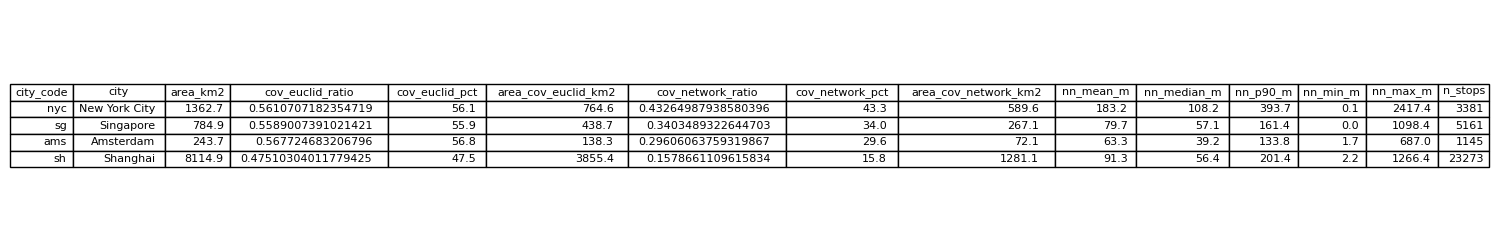

In [19]:
# ======================================================
# 5) Summarize detailed accessibility stats for each city
# ======================================================
import numpy as np

access_summary_rows = []

for c, stats in detail_stats.items():
    cov_euc = stats["coverage_500m_euclidean"]   
    cov_net = stats["coverage_500m_network"]     
    nn_gdf  = stats["nearest"]                   
    nn_dist = nn_gdf["nn_dist"].values

    area_total   = results[c]["area_km2"]
    area_euc     = cov_euc * area_total if cov_euc is not None else None
    area_net     = cov_net * area_total if cov_net is not None else None

    access_summary_rows.append({
        "city_code": c,
        "city": CITY_LABEL[c],
        "area_km2": area_total,

        # Euclidean 500m
        "cov_euclid_ratio": cov_euc,
        "cov_euclid_pct": cov_euc * 100 if cov_euc is not None else None,
        "area_cov_euclid_km2": area_euc,

        # Network 500m
        "cov_network_ratio": cov_net,
        "cov_network_pct": cov_net * 100 if cov_net is not None else None,
        "area_cov_network_km2": area_net,

        # Nearest Neighbor Distance
        "nn_mean_m": nn_dist.mean(),
        "nn_median_m": np.median(nn_dist),
        "nn_p90_m": np.percentile(nn_dist, 90),
        "nn_min_m": nn_dist.min(),
        "nn_max_m": nn_dist.max(),

        "n_stops": results[c]["n_stops"],
    })

access_summary_df = pd.DataFrame(access_summary_rows)

rounded_access_summary = access_summary_df.round({
    "area_km2": 1,
    "cov_euclid_pct": 1,
    "area_cov_euclid_km2": 1,
    "cov_network_pct": 1,
    "area_cov_network_km2": 1,
    "nn_mean_m": 1,
    "nn_median_m": 1,
    "nn_p90_m": 1,
    "nn_min_m": 1,
    "nn_max_m": 1,
})

print("\n=== Detailed Accessibility Summary ===")
print(rounded_access_summary)

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")

table = ax.table(
    cellText=rounded_access_summary.values,
    colLabels=rounded_access_summary.columns,
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(8)
table.auto_set_column_width(col=list(range(len(rounded_access_summary.columns))))

save_fig("detailed_accessibility_summary")
plt.show()

In [21]:
cov_euc_sh, _ = bus_coverage_analysis("sh", results["sh"], buffer_m=500, plot=False)
cov_net_sh, _ = bus_network_coverage("sh", results["sh"], buffer_m=500, street_buffer=40, plot=False)

print("Shanghai Euclidean 500m coverage:", cov_euc_sh)
print("Shanghai Network   500m coverage:", cov_net_sh)

Shanghai Euclidean 500m coverage: 0.47510304011779425
Shanghai Network   500m coverage: 0.1578661109615834
